In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Pytorch seed for reproducable results
torch.manual_seed(1000)
torch.set_deterministic(True)

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


In [ ]:
# constants
N_CLASSES = 9
SAVE_DIR = 'mush_saves'

In [ ]:
!mkdir Mushfixs
!unzip /content/drive/MyDrive/APS360_Project/Mushfixs.zip -d Mushfixs

In [ ]:
# load in full dataset
transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path = '/content/Mushfixs'
full_data = datasets.ImageFolder(path, transform=transform)

print('full dataset len: ', len(full_data))

full dataset len:  6677


In [ ]:
# create labels reverse dict
class_to_idx = full_data.class_to_idx
idx_to_class = {}

for key in full_data.class_to_idx:
  idx_to_class[class_to_idx[key]] = key

print(idx_to_class)

{0: 'Agaricus', 1: 'Amanita', 2: 'Boletus', 3: 'Cortinarius', 4: 'Entoloma', 5: 'Hygrocybe', 6: 'Lactarius', 7: 'Russula', 8: 'Suillus'}


In [ ]:
# Split into train, validation, and test sets
num_images = len(full_data)
train_len, val_len = int(0.7 * num_images), int(0.2 * num_images)
test_len = num_images - train_len - val_len

train_data, val_data, test_data = torch.utils.data.random_split(
    full_data,
    [train_len, val_len, test_len],
    generator=torch.Generator()
)
print('train/val/test: ', len(train_data), len(val_data), len(test_data))

train/val/test:  4673 1335 669


In [ ]:
# dataloader parameters
batch_size = 200
num_workers = 0

# dataloaders
def get_train_loader():
  return torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                     num_workers=num_workers, shuffle=True)

def get_val_loader():
  return torch.utils.data.DataLoader(val_data, batch_size=100, 
                                           num_workers=num_workers, shuffle=True)

def get_test_loader():
  return torch.utils.data.DataLoader(test_data, batch_size=100, 
                                     num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

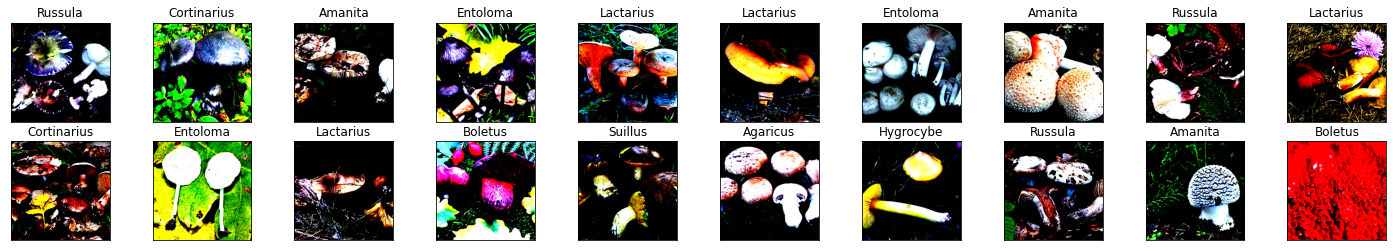

In [ ]:
# visualize a sample of the data
data_iter = iter(get_train_loader())
samples, labels = data_iter.next()
samples = samples.numpy()

fig = plt.figure(figsize=(25, 4))
for i in range(20):
  ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
  plt.imshow(np.transpose(samples[i], (1, 2, 0)))
  ax.set_title(idx_to_class[labels[i].item()])

In [ ]:
# get googlenet
import torchvision.models

In [ ]:
class MushNet(nn.Module):
    def __init__(self):
        super(MushNet, self).__init__()
        self.fc1 = nn.Linear(1000, 25)  # GoogleNet has 1000 output features
        self.fc2 = nn.Linear(25, 9)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(model, data_loader, googlenet):
    correct = 0
    total = 0

    for imgs, labels in iter(data_loader):
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
            model = model.cuda()
            googlenet = googlenet.cuda()

        output = model(googlenet(imgs))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        if torch.cuda.is_available():
            imgs = imgs.to('cpu')
            labels = labels.to('cpu')
            model = model.to('cpu')
            googlenet = googlenet.to('cpu')
            torch.cuda.empty_cache()
    
    return correct / total

In [ ]:
def plot_acc(iters, train_acc, val_acc):
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def plot_loss(iters, losses):
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
def train(model, batch_size=200, learning_rate=0.01, num_epochs=50, record=False):
    googlenet = torchvision.models.googlenet(pretrained=True)
    for param in googlenet.parameters():
        param.requires_grad = False

    train_loader, val_loader = get_train_loader(), get_val_loader()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    if record:
        if not os.path.isdir(SAVE_DIR):
            os.mkdir(SAVE_DIR)
        
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
                model = model.cuda()
                googlenet = googlenet.cuda()
                
            out = model(googlenet(imgs))             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # average loss
            avg_loss = float(loss)/batch_size

            # mini-batch accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            curr_train_acc = mini_batch_correct / mini_batch_total
            
            # validation accuracy
            curr_val_acc = get_accuracy(model, val_loader, googlenet)

            # save the current training information
            iters.append(n)
            losses.append(avg_loss)
            train_acc.append((curr_train_acc))
            val_acc.append(curr_val_acc) 
            
            # iter status
            print('epoch ', epoch, ' iter ', n, ': train acc: ', curr_train_acc, 
                  '  val acc: ', curr_val_acc, '  train loss: ', loss.item())
            
            # move everything back to cpu 
            if torch.cuda.is_available():
                imgs = imgs.to('cpu')
                labels = labels.to('cpu')
                model = model.to('cpu')
                googlenet = googlenet.to('cpu')
                torch.cuda.empty_cache()
            
            n += 1

        # Save the current model (checkpoint) to a file
        if record:
            model_path = (SAVE_DIR + '/Mushnet_' + str(batch_size) + '_' + 
                          str(learning_rate) + '_' + str(model.fc1.out_features) +
                          '_' + str(epoch))
            
            torch.save(model.state_dict(), model_path)

    # plotting
    plot_loss(iters, losses)
    plot_acc(iters, train_acc, val_acc)

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    if record:
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth



epoch  0  iter  0 : train acc:  0.14   val acc:  0.1258426966292135   train loss:  2.2145142555236816
epoch  0  iter  1 : train acc:  0.11   val acc:  0.13108614232209737   train loss:  2.230243682861328
epoch  0  iter  2 : train acc:  0.155   val acc:  0.1543071161048689   train loss:  2.1840670108795166
epoch  0  iter  3 : train acc:  0.145   val acc:  0.18726591760299627   train loss:  2.161670684814453
epoch  0  iter  4 : train acc:  0.205   val acc:  0.21198501872659176   train loss:  2.145634412765503
epoch  0  iter  5 : train acc:  0.215   val acc:  0.24044943820224718   train loss:  2.1327288150787354
epoch  0  iter  6 : train acc:  0.295   val acc:  0.2808988764044944   train loss:  2.0954785346984863
epoch  0  iter  7 : train acc:  0.28   val acc:  0.3041198501872659   train loss:  2.0756452083587646
epoch  0  iter  8 : train acc:  0.23   val acc:  0.32808988764044944   train loss:  2.07497239112854
epoch  0  iter  9 : train acc:  0.3   val acc:  0.35805243445692886   train 

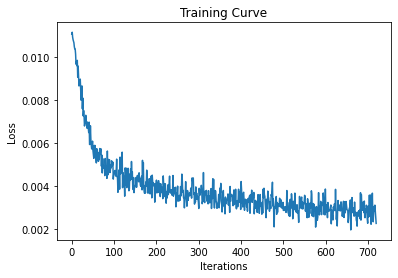

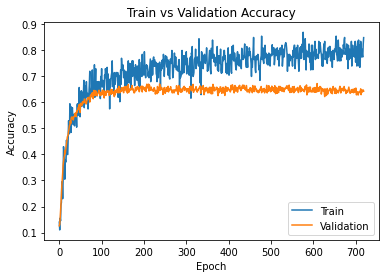

Final Training Accuracy: 0.8493150684931506
Final Validation Accuracy: 0.6434456928838951


In [ ]:
mushnet = MushNet()
train(mushnet, record=True, num_epochs=30)